In [ ]:
# Core PyTorch utilities
!pip install -q torchinfo torchview torchmetrics graphviz

# System dependency for graphviz (needed for SVG rendering)
!apt-get install -y graphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
import os

KAGGLE_USERNAME = "icdar pytorch"
KAGGLE_KEY = "KGAT_b08f085f57433fcea05687ada681f387"

In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "icdar pytorch"
os.environ["KAGGLE_KEY"] = "KGAT_b08f085f57433fcea05687ada681f387"

print("KAGGLE_USERNAME set:", "KAGGLE_USERNAME" in os.environ)
print("KAGGLE_KEY set:", "KAGGLE_KEY" in os.environ)


KAGGLE_USERNAME set: True
KAGGLE_KEY set: True


In [ ]:
!pip install -q kaggle h5py torch torchvision torchmetrics tqdm seaborn matplotlib scikit-learn


In [ ]:
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassAUROC
)

from kaggle.api.kaggle_api_extended import KaggleApi

sns.set_style("darkgrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)
from torchinfo import summary
from torchview import draw_graph

In [ ]:
import json
import os

os.makedirs("/root/.config/kaggle", exist_ok=True)

kaggle_json_path = "/root/.config/kaggle/kaggle.json"

with open(kaggle_json_path, "w") as f:
    json.dump({
        "username": os.environ["KAGGLE_USERNAME"],
        "key": os.environ["KAGGLE_KEY"]
    }, f)

os.chmod(kaggle_json_path, 0o600)

print("kaggle.json created at:", kaggle_json_path)


kaggle.json created at: /root/.config/kaggle/kaggle.json


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
# =========================
# KAGGLE DATASET DOWNLOAD
# =========================
DATA_DIR = "brain_tumor_44c"
DATASET = "fernando2rad/brain-tumor-mri-images-44c"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)




Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
Dataset downloaded to: brain_tumor_44c


In [ ]:
import os

for root, dirs, files in os.walk(DATA_DIR):
    print(root)
    break


brain_tumor_44c


In [ ]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))


In [ ]:
import os

for root, dirs, files in os.walk(DATA_DIR):
    print("ROOT:", root)
    print("DIRS:", dirs)
    print("FILES:", files[:5])
    break


ROOT: brain_tumor_44c
DIRS: ['Meduloblastoma T1C+', 'Ganglioglioma T1C+', 'Granuloma T1', 'Carcinoma T1C+', '_NORMAL T2', 'Granuloma T1C+', 'Meduloblastoma T1', 'Germinoma T1C+', 'Meningioma T1', 'Carcinoma T2', 'Astrocitoma T1C+', 'Schwannoma T1C+', 'Papiloma T2', 'Tuberculoma T2', 'Meningioma T1C+', 'Schwannoma T1', 'Ganglioglioma T1', 'Ependimoma T1C+', 'Glioblastoma T1C+', 'Schwannoma T2', 'Glioblastoma T1', 'Oligodendroglioma T1', 'Tuberculoma T1', 'Ependimoma T2', 'Meningioma T2', 'Oligodendroglioma T1C+', 'Neurocitoma T1C+', 'Papiloma T1C+', 'Carcinoma T1', 'Astrocitoma T1', 'Ganglioglioma T2', 'Ependimoma T1', 'Meduloblastoma T2', 'Astrocitoma T2', 'Neurocitoma T1', 'Oligodendroglioma T2', 'Germinoma T2', 'Papiloma T1', 'Glioblastoma T2', 'Germinoma T1', 'Tuberculoma T1C+', '_NORMAL T1', 'Granuloma T2', 'Neurocitoma T2']
FILES: []


In [ ]:
from pathlib import Path
import pandas as pd
import os

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

paths, labels = [], []

# ----------------------------------
# Collect class folders (leaf dirs)
# ----------------------------------
class_dirs = []
for root, dirs, files in os.walk(DATA_DIR):
    if any(f.lower().endswith(IMAGE_EXTS) for f in files):
        class_dirs.append(root)

class_dirs = sorted(class_dirs)

# ----------------------------------
# Create class ↔ index mapping
# ----------------------------------
class_to_idx = {
    Path(d).name: idx for idx, d in enumerate(class_dirs)
}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Number of classes:", len(class_to_idx))

# ----------------------------------
# Build dataframe
# ----------------------------------
for root, _, files in os.walk(DATA_DIR):
    class_name = Path(root).name

    if class_name not in class_to_idx:
        continue

    label = class_to_idx[class_name]

    for f in files:
        if f.lower().endswith(IMAGE_EXTS):
            paths.append(os.path.join(root, f))
            labels.append(label)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print("Total images:", len(df))
print("Class distribution:\n", df["label"].value_counts().sort_index())


Number of classes: 44
Total images: 4478
Class distribution:
 label
0     176
1     232
2     171
3      66
4     112
5      73
6      45
7      48
8      57
9      20
10     18
11     23
12     27
13     40
14     33
15     55
16     94
17     55
18     30
19     31
20     17
21     23
22     67
23     41
24    272
25    369
26    233
27    130
28    223
29    104
30     86
31     72
32     66
33     66
34    108
35     63
36    148
37    194
38    123
39     28
40     84
41     33
42    251
43    271
Name: count, dtype: int64


In [ ]:
num_classes = len(class_to_idx)
print("num_classes =", num_classes)


num_classes = 44


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.20,
    stratify=train_df["label"],
    random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2865
Val: 717
Test: 896


In [ ]:
from PIL import Image

class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16
)



In [ ]:
def apply_avg_2max_pool_to_image(img_tensor, pool_layer):
    """
    img_tensor: torch.Tensor of shape (3, H, W)
    returns pooled image resized back to original size
    """
    img = img_tensor.unsqueeze(0)  # (1, 3, H, W)

    pooled_channels = []
    for c in range(3):
        ch = img[:, c:c+1, :, :]          # (1,1,H,W)
        pooled = pool_layer(ch)           # downsampled
        pooled = torch.nn.functional.interpolate(
            pooled, size=img.shape[-2:], mode="bilinear", align_corners=False
        )
        pooled_channels.append(pooled)

    pooled_img = torch.cat(pooled_channels, dim=1)
    return pooled_img.squeeze(0)


In [ ]:
def visualize_original_vs_pooled(dataset, pool_layer, num_images=3):
    """
    Shows:
    Top row    -> Original images
    Bottom row -> Avg − 2×Max pooled images
    """
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(4 * num_images, 6))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]  # img: (3,224,224)

        pooled_img = apply_avg_2max_pool_to_image(img, pool_layer)

        # Convert to display format
        orig = img.permute(1, 2, 0).cpu().numpy()
        pooled = pooled_img.permute(1, 2, 0).cpu().numpy()

        # Normalize for display
        orig = (orig - orig.min()) / (orig.max() - orig.min() + 1e-8)
        pooled = (pooled - pooled.min()) / (pooled.max() - pooled.min() + 1e-8)

        # ---- ORIGINAL ----
        plt.subplot(2, num_images, i + 1)
        plt.imshow(orig, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # ---- POOLED ----
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(pooled, cmap="gray")
        plt.title("Avg − 2×Max pooled")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn

class AvgTwiceMaxPooling2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.max = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.avg(x) - 2 * self.max(x)


In [ ]:
import random
import matplotlib.pyplot as plt

def visualize_original_vs_pooled(dataset, device, num_images=3):
    pool_layer = AvgTwiceMaxPooling2D().to(device)
    pool_layer.eval()

    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(4 * num_images, 6))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img = img.to(device)

        with torch.no_grad():
            pooled_img = apply_avg_2max_pool_to_image(img, pool_layer)

        orig = img.permute(1, 2, 0).cpu().numpy()
        pooled = pooled_img.permute(1, 2, 0).cpu().numpy()

        # Normalize for display
        orig = (orig - orig.min()) / (orig.max() - orig.min() + 1e-8)
        pooled = (pooled - pooled.min()) / (pooled.max() - pooled.min() + 1e-8)

        # Original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(orig, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Pooled
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(pooled, cmap="gray")
        plt.title("Avg − 2×Max pooled")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


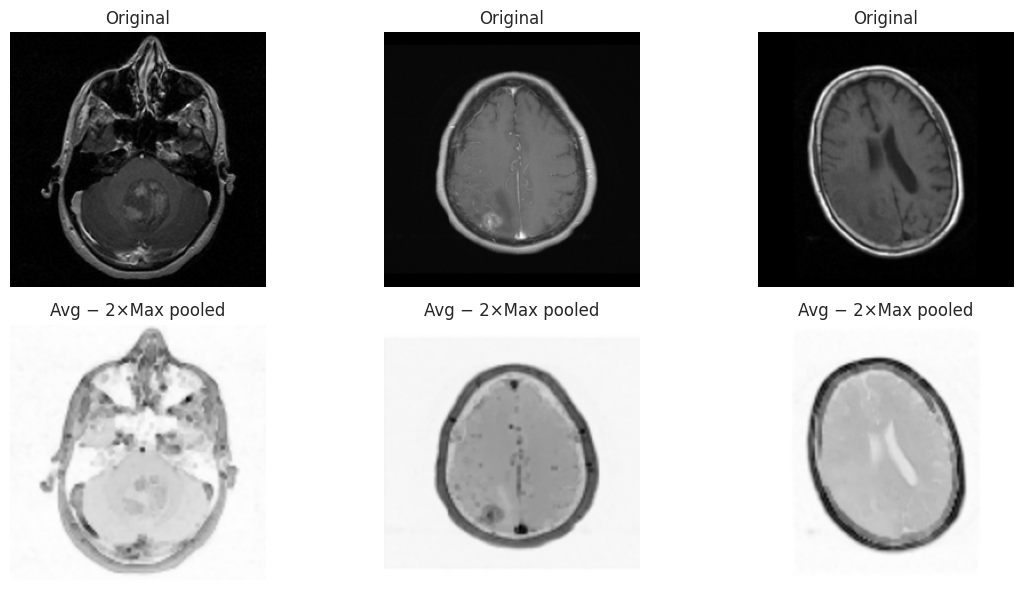

In [ ]:
visualize_original_vs_pooled(
    dataset=test_loader.dataset,  # or train_loader.dataset
    device=device,
    num_images=3
)


In [ ]:
# =========================
# ViT BLOCK (7×7 patch, stride=7, embed=64)
# =========================
class SimpleViT(nn.Module):
    def __init__(self, in_channels=34, embed_dim=128, num_heads=4, depth=1):
        super().__init__()

        self.patch_embed = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=7,
            stride=4
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
            activation="gelu"
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=depth
        )

    def forward(self, x):
        # x: (B, 55, 28, 28)
        x = self.patch_embed(x)              # (B, 64, 4, 4)
        x = x.flatten(2).transpose(1, 2)     # (B, 16, 64)
        x = self.transformer(x)              # (B, 16, 64)
        return x.mean(dim=1)                 # (B, 64)


In [ ]:
import torch
import torch.nn as nn

# =========================
# MRINet
# =========================
class MRINet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # =========================
        # Early CNN layers
        # =========================
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 21, 3, padding=1),
            nn.BatchNorm2d(21),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(21, 34, 3, padding=1),
            nn.BatchNorm2d(34),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.atm = nn.Sequential(
            AvgTwiceMaxPooling2D(),
            nn.GELU()
        )

        # =========================
        # 55-channel block
        # =========================
        self.conv3 = nn.Sequential(
            nn.Conv2d(34, 55, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(55)
        )

        self.pool_conv_14 = nn.Sequential(
            AvgTwiceMaxPooling2D(),      # 28×28 → 14×14
            nn.Conv2d(55, 24, 3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(24)
        )

        # =========================
        # Main CNN path
        # =========================
        self.conv4 = nn.Sequential(
            nn.Conv2d(89, 89, 3, padding=1),
            nn.BatchNorm2d(89),
            nn.MaxPool2d(2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(113, 144, 3, padding=1),
            nn.BatchNorm2d(144),
            nn.MaxPool2d(2)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(144, 233, 3, padding=1),
            nn.Conv2d(233, 233, 3, padding=1, groups=233),
            nn.BatchNorm2d(233)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(233, 233, 3, padding=1),
            nn.Conv2d(233, 233, 3, padding=1, groups=233),
            nn.BatchNorm2d(233)
        )

        # =========================
        # GAP for CNN branch
        # =========================
        self.gap = nn.AdaptiveAvgPool2d(1)

        # =========================
        # 55 → 21 → ViT (CLEAN)
        # =========================
        self.c2_to_vit = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),  # 14 → 28
            nn.Conv2d(113, 55, kernel_size=3, padding=1),
            nn.BatchNorm2d(55)
        )

        self.c2_reduce_to_21 = nn.Sequential(
            nn.Conv2d(55, 21, kernel_size=1, bias=False),
            nn.BatchNorm2d(21)
        )

        self.vit = SimpleViT(
            in_channels=21,
            embed_dim=128
        )

        # =========================
        # Final classifier
        # =========================
        self.fc = nn.Linear(233 + 128, num_classes)

    def forward(self, x):
        # ---- Early layers ----
        x1 = self.conv1(x)           # (B, 21, 112, 112)
        x2 = self.conv2(x1)          # (B, 34, 56, 56)

        atm1 = self.atm(x2)          # (B, 34, 28, 28)

        # ---- 55-channel block ----
        x3 = self.conv3(x2)          # (B, 55, 28, 28)
        concat1 = torch.cat([x3, atm1], dim=1)   # (B, 89, 28, 28)

        blk = self.pool_conv_14(x3)  # (B, 24, 14, 14)

        # ---- CNN main path ----
        x4 = self.conv4(concat1)     # (B, 89, 14, 14)
        concat2 = torch.cat([x4, blk], dim=1)    # (B, 113, 14, 14)

        x5 = self.conv5(concat2)     # (B, 144, 7, 7)
        x6 = self.conv6(x5)          # (B, 233, 7, 7)
        x7 = self.conv7(x6)          # (B, 233, 7, 7)

        gap_feat = self.gap(x7).flatten(1)  # (B, 233)

        # ---- ViT path (STRICT: 55 → 21 ONLY) ----
        vit_c2 = self.c2_to_vit(concat2)         # (B, 55, 28, 28)
        vit_input = self.c2_reduce_to_21(vit_c2) # (B, 21, 28, 28)

        vit_feat = self.vit(vit_input)           # (B, 64)

        # ---- Final fusion ----
        fused = torch.cat([gap_feat, vit_feat], dim=1)
        return self.fc(fused)


In [ ]:
from torchinfo import summary

model = MRINet(num_classes).to(device)

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=5
)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
MRINet                                             [1, 3, 224, 224]          [1, 44]                   --                        --
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 21, 112, 112]         --                        --
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 21, 224, 224]         588                       [3, 3]
│    └─BatchNorm2d: 2-2                            [1, 21, 224, 224]         [1, 21, 224, 224]         42                        --
│    └─ReLU: 2-3                                   [1, 21, 224, 224]         [1, 21, 224, 224]         --                        --
│    └─MaxPool2d: 2-4                              [1, 21, 224, 224]         [1, 21, 112, 112]         --                        2
├─Sequential: 1-2                                  [1, 21, 112,

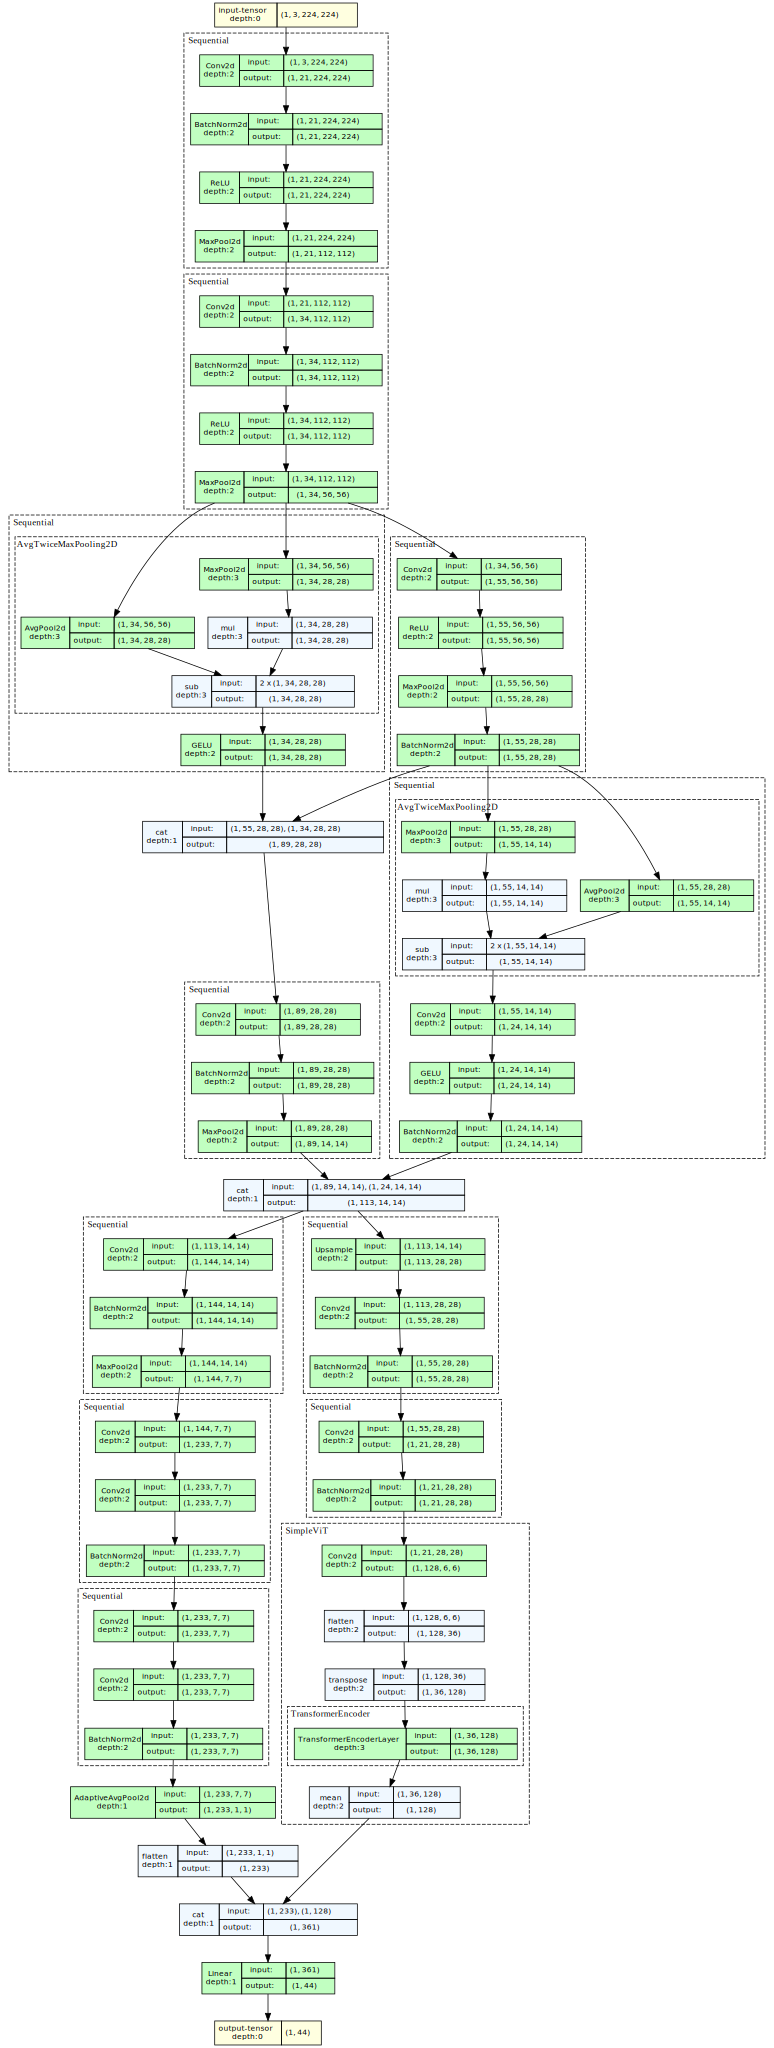

In [ ]:


!pip install -q torchview graphviz
from torchview import draw_graph
from IPython.display import SVG, display

dummy = torch.randn(1, 3, 224, 224).to(device)

graph = draw_graph(
    model,
    input_data=dummy,
    expand_nested=True,
    graph_name="MRINet",
    save_graph=False
)

display(SVG(graph.visual_graph.pipe(format="svg")))


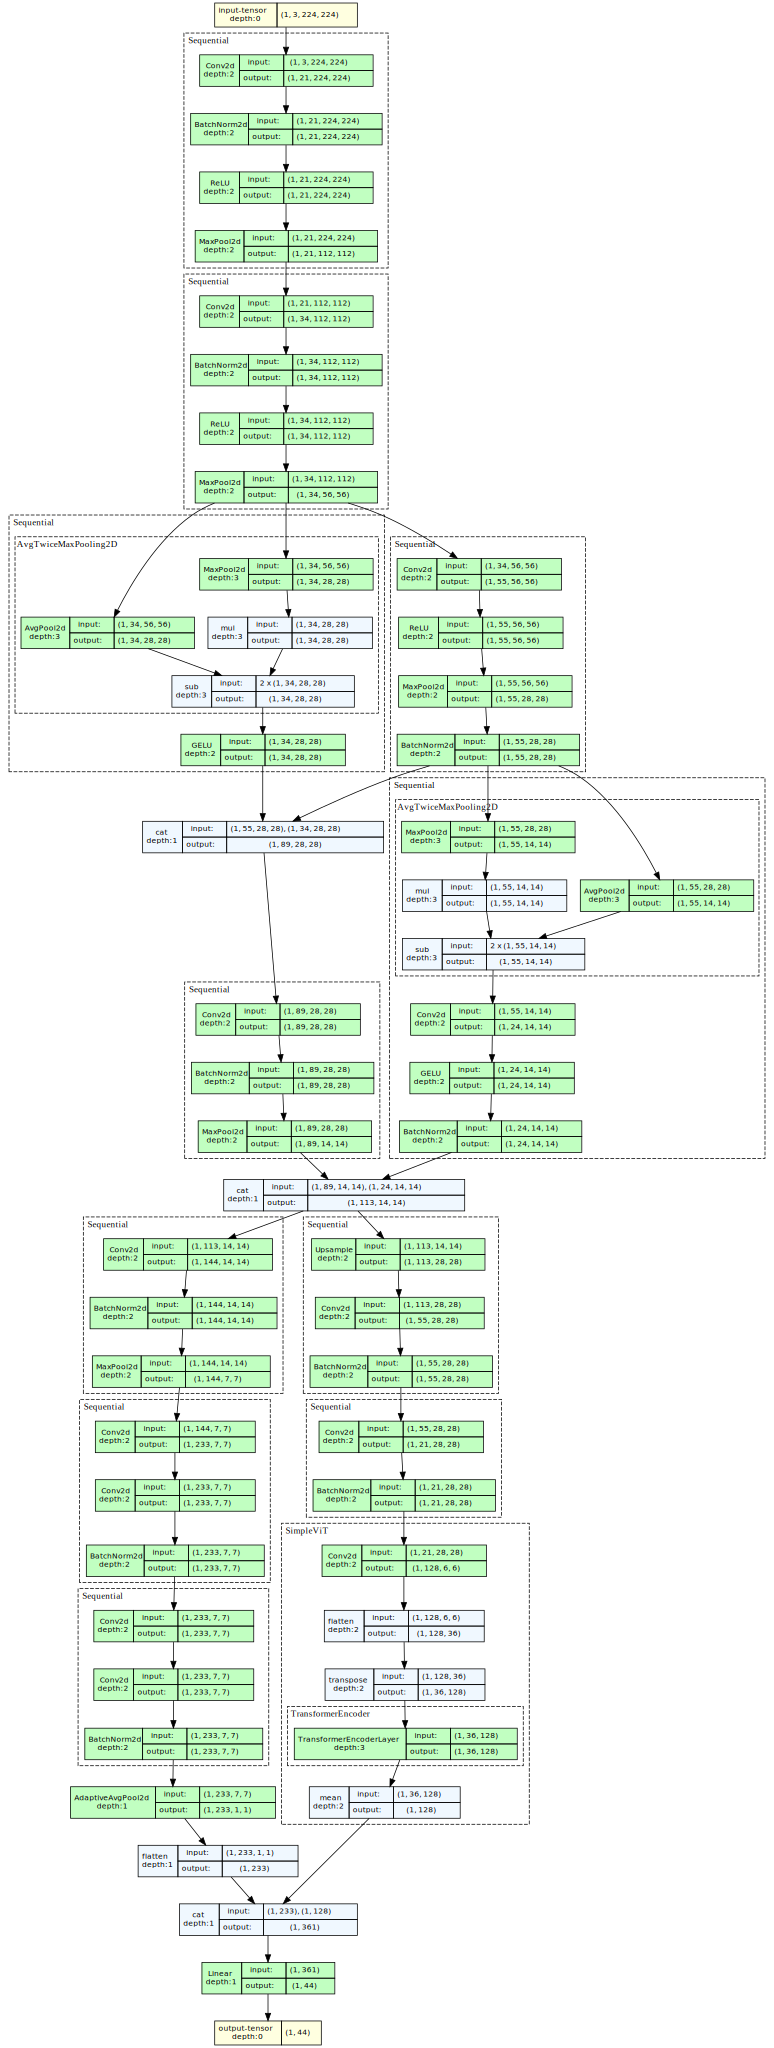

In [ ]:
from torchview import draw_graph
from IPython.display import SVG, display

dummy_input = torch.randn(1, 3, 224, 224).to(device)

graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="MRINet",
    save_graph=True,              # IMPORTANT
    filename="MRINet_BlockDiagram",
    directory="."
)

# Display inline
svg = graph.visual_graph.pipe(format="svg")
display(SVG(svg))


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Fixed LR for first 15 epochs
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: 1.0
)

adaptive_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)



In [ ]:

train_metrics = {
    "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
    "auc": MulticlassAUROC(num_classes=num_classes).to(device),
    "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
}

val_metrics = {
    "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
    "auc": MulticlassAUROC(num_classes=num_classes).to(device),
    "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
}

history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "auc": [], "val_auc": [],
    "mcc": [], "val_mcc": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": []
}


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def multiclass_specificity_sensitivity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    specificity = []
    sensitivity = []

    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        specificity.append(tn / (tn + fp + 1e-8))
        sensitivity.append(tp / (tp + fn + 1e-8))

    return float(np.mean(specificity)), float(np.mean(sensitivity))


In [ ]:
EPOCHS = 40

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0.0
    train_preds, train_targets = [], []

    pbar = tqdm(
        train_loader,
        desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]",
        leave=True
    )

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = out.argmax(dim=1)
        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)


    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(
        train_targets, train_preds, num_classes
    )

    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(
        f"Metrics - loss: {train_loss/len(train_loader):.4f}, "
        f"accuracy: {train_out['acc']:.4f}, "
        f"precision: {train_out['precision']:.4f}, "
        f"recall: {train_out['recall']:.4f}, "
        f"f1_score: {train_out['f1']:.4f}, "
        f"specificity: {train_spec:.4f}, "
        f"sensitivity: {train_sens:.4f}, "
        f"mcc: {train_out['mcc']:.4f}, "
        f"auc: {train_out['auc']:.4f}"
    )
# ===== STORE TRAIN HISTORY =====
    history["loss"].append(train_loss / len(train_loader))
    history["accuracy"].append(train_out["acc"])
    history["precision"].append(train_out["precision"])
    history["recall"].append(train_out["recall"])
    history["f1"].append(train_out["f1"])
    history["auc"].append(train_out["auc"])
    history["mcc"].append(train_out["mcc"])
    history["specificity"].append(train_spec)
    history["sensitivity"].append(train_sens)

    for m in train_metrics.values():
        m.reset()

    # ================= VALID =================
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    pbar = tqdm(val_loader, desc="Validating Model", leave=True)

    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item()
            preds = out.argmax(dim=1)

            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(
        val_targets, val_preds, num_classes
    )

    val_out = {k: v.compute().item() for k, v in val_metrics.items()}
    # ================= SCHEDULER STEP =================
    if epoch < 15:
        warmup_scheduler.step()
    else:
        adaptive_scheduler.step(val_loss / len(val_loader))

    # Optional: print LR
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Current LR: {current_lr:.6e}")

    print(
        f"Metrics - loss: {val_loss/len(val_loader):.4f}, "
        f"accuracy: {val_out['acc']:.4f}, "
        f"precision: {val_out['precision']:.4f}, "
        f"recall: {val_out['recall']:.4f}, "
        f"f1_score: {val_out['f1']:.4f}, "
        f"specificity: {val_spec:.4f}, "
        f"sensitivity: {val_sens:.4f}, "
        f"mcc: {val_out['mcc']:.4f}, "
        f"auc: {val_out['auc']:.4f}"
    )
    # ===== STORE VALID HISTORY =====
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_accuracy"].append(val_out["acc"])
    history["val_precision"].append(val_out["precision"])
    history["val_recall"].append(val_out["recall"])
    history["val_f1"].append(val_out["f1"])
    history["val_auc"].append(val_out["auc"])
    history["val_mcc"].append(val_out["mcc"])
    history["val_specificity"].append(val_spec)
    history["val_sensitivity"].append(val_sens)


    for m in val_metrics.values():
        m.reset()


Training Model - Epoch [1/40]: 100%|██████████| 180/180 [00:27<00:00,  6.56it/s]


Metrics - loss: 2.6135, accuracy: 0.1587, precision: 0.1642, recall: 0.1587, f1_score: 0.1452, specificity: 0.9832, sensitivity: 0.1587, mcc: 0.2627, auc: 0.8196


Validating Model: 100%|██████████| 45/45 [00:10<00:00,  4.38it/s]


Current LR: 5.000000e-04
Metrics - loss: 2.6301, accuracy: 0.1496, precision: 0.1479, recall: 0.1496, f1_score: 0.1261, specificity: 0.9828, sensitivity: 0.1496, mcc: 0.2547, auc: 0.8764


Training Model - Epoch [2/40]: 100%|██████████| 180/180 [00:24<00:00,  7.49it/s]


Metrics - loss: 1.7827, accuracy: 0.3055, precision: 0.3655, recall: 0.3055, f1_score: 0.2965, specificity: 0.9880, sensitivity: 0.3055, mcc: 0.4727, auc: 0.9352


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.46it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.6426, accuracy: 0.3774, precision: 0.4364, recall: 0.3774, f1_score: 0.3722, specificity: 0.9890, sensitivity: 0.3774, mcc: 0.5258, auc: 0.9550


Training Model - Epoch [3/40]: 100%|██████████| 180/180 [00:22<00:00,  7.87it/s]


Metrics - loss: 1.3610, accuracy: 0.4282, precision: 0.5355, recall: 0.4282, f1_score: 0.4382, specificity: 0.9907, sensitivity: 0.4282, mcc: 0.5923, auc: 0.9645


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.16it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.7444, accuracy: 0.3337, precision: 0.4422, recall: 0.3337, f1_score: 0.3291, specificity: 0.9880, sensitivity: 0.3337, mcc: 0.4814, auc: 0.9551


Training Model - Epoch [4/40]: 100%|██████████| 180/180 [00:23<00:00,  7.73it/s]


Metrics - loss: 1.1341, accuracy: 0.5178, precision: 0.6423, recall: 0.5178, f1_score: 0.5417, specificity: 0.9922, sensitivity: 0.5178, mcc: 0.6553, auc: 0.9776


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.3803, accuracy: 0.4570, precision: 0.5794, recall: 0.4570, f1_score: 0.4741, specificity: 0.9909, sensitivity: 0.4570, mcc: 0.6022, auc: 0.9660


Training Model - Epoch [5/40]: 100%|██████████| 180/180 [00:23<00:00,  7.63it/s]


Metrics - loss: 0.8332, accuracy: 0.6442, precision: 0.7544, recall: 0.6442, f1_score: 0.6751, specificity: 0.9945, sensitivity: 0.6442, mcc: 0.7589, auc: 0.9873


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.53it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.1971, accuracy: 0.5946, precision: 0.6489, recall: 0.5946, f1_score: 0.5832, specificity: 0.9923, sensitivity: 0.5946, mcc: 0.6600, auc: 0.9766


Training Model - Epoch [6/40]: 100%|██████████| 180/180 [00:24<00:00,  7.49it/s]


Metrics - loss: 0.6537, accuracy: 0.7304, precision: 0.8151, recall: 0.7304, f1_score: 0.7586, specificity: 0.9958, sensitivity: 0.7304, mcc: 0.8165, auc: 0.9935


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.28it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.8910, accuracy: 0.6554, precision: 0.7707, recall: 0.6554, f1_score: 0.6743, specificity: 0.9939, sensitivity: 0.6554, mcc: 0.7320, auc: 0.9879


Training Model - Epoch [7/40]: 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]


Metrics - loss: 0.4926, accuracy: 0.8012, precision: 0.8600, recall: 0.8012, f1_score: 0.8223, specificity: 0.9969, sensitivity: 0.8012, mcc: 0.8656, auc: 0.9964


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.71it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.0264, accuracy: 0.5966, precision: 0.7153, recall: 0.5966, f1_score: 0.6101, specificity: 0.9925, sensitivity: 0.5966, mcc: 0.6740, auc: 0.9849


Training Model - Epoch [8/40]: 100%|██████████| 180/180 [00:23<00:00,  7.72it/s]


Metrics - loss: 0.4051, accuracy: 0.8554, precision: 0.8912, recall: 0.8554, f1_score: 0.8704, specificity: 0.9975, sensitivity: 0.8554, mcc: 0.8918, auc: 0.9981


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.84it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.7704, accuracy: 0.7066, precision: 0.7631, recall: 0.7066, f1_score: 0.6982, specificity: 0.9947, sensitivity: 0.7066, mcc: 0.7682, auc: 0.9908


Training Model - Epoch [9/40]: 100%|██████████| 180/180 [00:23<00:00,  7.74it/s]


Metrics - loss: 0.3780, accuracy: 0.8405, precision: 0.8861, recall: 0.8405, f1_score: 0.8575, specificity: 0.9975, sensitivity: 0.8405, mcc: 0.8889, auc: 0.9979


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.24it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.8528, accuracy: 0.7022, precision: 0.7412, recall: 0.7022, f1_score: 0.6897, specificity: 0.9945, sensitivity: 0.7022, mcc: 0.7565, auc: 0.9894


Training Model - Epoch [10/40]: 100%|██████████| 180/180 [00:23<00:00,  7.76it/s]


Metrics - loss: 0.2005, accuracy: 0.9414, precision: 0.9583, recall: 0.9414, f1_score: 0.9490, specificity: 0.9990, sensitivity: 0.9414, mcc: 0.9546, auc: 0.9996


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.67it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.8477, accuracy: 0.7686, precision: 0.8043, recall: 0.7686, f1_score: 0.7488, specificity: 0.9949, sensitivity: 0.7686, mcc: 0.7742, auc: 0.9910


Training Model - Epoch [11/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.1750, accuracy: 0.9546, precision: 0.9704, recall: 0.9546, f1_score: 0.9617, specificity: 0.9992, sensitivity: 0.9546, mcc: 0.9630, auc: 0.9997


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.75it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.7573, accuracy: 0.8039, precision: 0.8146, recall: 0.8039, f1_score: 0.7851, specificity: 0.9954, sensitivity: 0.8039, mcc: 0.7971, auc: 0.9932


Training Model - Epoch [12/40]: 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]


Metrics - loss: 0.1260, accuracy: 0.9707, precision: 0.9825, recall: 0.9707, f1_score: 0.9761, specificity: 0.9995, sensitivity: 0.9707, mcc: 0.9771, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.81it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.6853, accuracy: 0.8036, precision: 0.8130, recall: 0.8036, f1_score: 0.7831, specificity: 0.9958, sensitivity: 0.8036, mcc: 0.8171, auc: 0.9937


Training Model - Epoch [13/40]: 100%|██████████| 180/180 [00:22<00:00,  7.96it/s]


Metrics - loss: 0.1430, accuracy: 0.9520, precision: 0.9552, recall: 0.9520, f1_score: 0.9532, specificity: 0.9992, sensitivity: 0.9520, mcc: 0.9644, auc: 0.9998


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.24it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.0717, accuracy: 0.6556, precision: 0.7823, recall: 0.6556, f1_score: 0.6627, specificity: 0.9939, sensitivity: 0.6556, mcc: 0.7334, auc: 0.9855


Training Model - Epoch [14/40]: 100%|██████████| 180/180 [00:23<00:00,  7.79it/s]


Metrics - loss: 0.1755, accuracy: 0.9451, precision: 0.9565, recall: 0.9451, f1_score: 0.9504, specificity: 0.9989, sensitivity: 0.9451, mcc: 0.9524, auc: 0.9997


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.65it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.7915, accuracy: 0.7595, precision: 0.8448, recall: 0.7595, f1_score: 0.7672, specificity: 0.9954, sensitivity: 0.7595, mcc: 0.8016, auc: 0.9930


Training Model - Epoch [15/40]: 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]


Metrics - loss: 0.1049, accuracy: 0.9767, precision: 0.9805, recall: 0.9767, f1_score: 0.9784, specificity: 0.9995, sensitivity: 0.9767, mcc: 0.9786, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.73it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.6573, accuracy: 0.7499, precision: 0.8645, recall: 0.7499, f1_score: 0.7741, specificity: 0.9963, sensitivity: 0.7499, mcc: 0.8394, auc: 0.9932


Training Model - Epoch [16/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.2734, accuracy: 0.9064, precision: 0.9244, recall: 0.9064, f1_score: 0.9142, specificity: 0.9982, sensitivity: 0.9064, mcc: 0.9230, auc: 0.9991


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.13it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.1900, accuracy: 0.5889, precision: 0.7001, recall: 0.5889, f1_score: 0.5935, specificity: 0.9927, sensitivity: 0.5889, mcc: 0.6829, auc: 0.9853


Training Model - Epoch [17/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.1326, accuracy: 0.9596, precision: 0.9628, recall: 0.9596, f1_score: 0.9607, specificity: 0.9992, sensitivity: 0.9596, mcc: 0.9641, auc: 0.9998


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.83it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.8115, accuracy: 0.7283, precision: 0.8196, recall: 0.7283, f1_score: 0.7457, specificity: 0.9951, sensitivity: 0.7283, mcc: 0.7886, auc: 0.9926


Training Model - Epoch [18/40]: 100%|██████████| 180/180 [00:23<00:00,  7.76it/s]


Metrics - loss: 0.0899, accuracy: 0.9856, precision: 0.9873, recall: 0.9856, f1_score: 0.9863, specificity: 0.9996, sensitivity: 0.9856, mcc: 0.9837, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.77it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.7569, accuracy: 0.7606, precision: 0.8577, recall: 0.7606, f1_score: 0.7637, specificity: 0.9956, sensitivity: 0.7606, mcc: 0.8081, auc: 0.9923


Training Model - Epoch [19/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.2616, accuracy: 0.9185, precision: 0.9292, recall: 0.9185, f1_score: 0.9229, specificity: 0.9984, sensitivity: 0.9185, mcc: 0.9292, auc: 0.9992


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.00it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.9346, accuracy: 0.7366, precision: 0.7568, recall: 0.7366, f1_score: 0.6948, specificity: 0.9945, sensitivity: 0.7366, mcc: 0.7596, auc: 0.9884


Training Model - Epoch [20/40]: 100%|██████████| 180/180 [00:22<00:00,  7.89it/s]


Metrics - loss: 0.2679, accuracy: 0.8994, precision: 0.9216, recall: 0.8994, f1_score: 0.9093, specificity: 0.9982, sensitivity: 0.8994, mcc: 0.9230, auc: 0.9991


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.22it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.6764, accuracy: 0.8013, precision: 0.8222, recall: 0.8013, f1_score: 0.7774, specificity: 0.9957, sensitivity: 0.8013, mcc: 0.8083, auc: 0.9932


Training Model - Epoch [21/40]: 100%|██████████| 180/180 [00:23<00:00,  7.74it/s]


Metrics - loss: 0.0768, accuracy: 0.9846, precision: 0.9844, recall: 0.9846, f1_score: 0.9844, specificity: 0.9997, sensitivity: 0.9846, mcc: 0.9851, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.83it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5225, accuracy: 0.8434, precision: 0.8780, recall: 0.8434, f1_score: 0.8476, specificity: 0.9970, sensitivity: 0.8434, mcc: 0.8669, auc: 0.9945


Training Model - Epoch [22/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.0533, accuracy: 0.9942, precision: 0.9965, recall: 0.9942, f1_score: 0.9953, specificity: 0.9999, sensitivity: 0.9942, mcc: 0.9942, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.82it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.4612, accuracy: 0.8655, precision: 0.9186, recall: 0.8655, f1_score: 0.8827, specificity: 0.9976, sensitivity: 0.8655, mcc: 0.8970, auc: 0.9948


Training Model - Epoch [23/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0495, accuracy: 0.9913, precision: 0.9919, recall: 0.9913, f1_score: 0.9916, specificity: 0.9998, sensitivity: 0.9913, mcc: 0.9906, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.17it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.6185, accuracy: 0.8454, precision: 0.8651, recall: 0.8454, f1_score: 0.8360, specificity: 0.9967, sensitivity: 0.8454, mcc: 0.8557, auc: 0.9935


Training Model - Epoch [24/40]: 100%|██████████| 180/180 [00:22<00:00,  7.87it/s]


Metrics - loss: 0.0807, accuracy: 0.9853, precision: 0.9902, recall: 0.9853, f1_score: 0.9876, specificity: 0.9997, sensitivity: 0.9853, mcc: 0.9873, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.42it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5902, accuracy: 0.8164, precision: 0.8576, recall: 0.8164, f1_score: 0.8204, specificity: 0.9970, sensitivity: 0.8164, mcc: 0.8670, auc: 0.9931


Training Model - Epoch [25/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.0820, accuracy: 0.9903, precision: 0.9886, recall: 0.9903, f1_score: 0.9894, specificity: 0.9997, sensitivity: 0.9903, mcc: 0.9848, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.6079, accuracy: 0.8434, precision: 0.8371, recall: 0.8434, f1_score: 0.8261, specificity: 0.9968, sensitivity: 0.8434, mcc: 0.8585, auc: 0.9930


Training Model - Epoch [26/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0661, accuracy: 0.9864, precision: 0.9887, recall: 0.9864, f1_score: 0.9875, specificity: 0.9997, sensitivity: 0.9864, mcc: 0.9873, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.37it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.6034, accuracy: 0.8391, precision: 0.8829, recall: 0.8391, f1_score: 0.8446, specificity: 0.9969, sensitivity: 0.8391, mcc: 0.8629, auc: 0.9931


Training Model - Epoch [27/40]: 100%|██████████| 180/180 [00:23<00:00,  7.82it/s]


Metrics - loss: 0.0339, accuracy: 0.9985, precision: 0.9983, recall: 0.9985, f1_score: 0.9984, specificity: 0.9999, sensitivity: 0.9985, mcc: 0.9960, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.26it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.4670, accuracy: 0.8606, precision: 0.9070, recall: 0.8606, f1_score: 0.8737, specificity: 0.9975, sensitivity: 0.8606, mcc: 0.8913, auc: 0.9959


Training Model - Epoch [28/40]: 100%|██████████| 180/180 [00:23<00:00,  7.77it/s]


Metrics - loss: 0.0384, accuracy: 0.9985, precision: 0.9984, recall: 0.9985, f1_score: 0.9984, specificity: 0.9999, sensitivity: 0.9985, mcc: 0.9964, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.4644, accuracy: 0.8739, precision: 0.9093, recall: 0.8739, f1_score: 0.8829, specificity: 0.9976, sensitivity: 0.8739, mcc: 0.8927, auc: 0.9959


Training Model - Epoch [29/40]: 100%|██████████| 180/180 [00:23<00:00,  7.81it/s]


Metrics - loss: 0.0313, accuracy: 0.9992, precision: 0.9991, recall: 0.9992, f1_score: 0.9991, specificity: 0.9999, sensitivity: 0.9992, mcc: 0.9975, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.85it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.4441, accuracy: 0.8740, precision: 0.9203, recall: 0.8740, f1_score: 0.8896, specificity: 0.9977, sensitivity: 0.8740, mcc: 0.8985, auc: 0.9955


Training Model - Epoch [30/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0362, accuracy: 0.9989, precision: 0.9992, recall: 0.9989, f1_score: 0.9990, specificity: 0.9999, sensitivity: 0.9989, mcc: 0.9975, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.31it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.4592, accuracy: 0.8446, precision: 0.9134, recall: 0.8446, f1_score: 0.8626, specificity: 0.9976, sensitivity: 0.8446, mcc: 0.8970, auc: 0.9956


Training Model - Epoch [31/40]: 100%|██████████| 180/180 [00:22<00:00,  7.88it/s]


Metrics - loss: 0.0305, accuracy: 0.9980, precision: 0.9983, recall: 0.9980, f1_score: 0.9981, specificity: 0.9999, sensitivity: 0.9980, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.95it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.4788, accuracy: 0.8592, precision: 0.9057, recall: 0.8592, f1_score: 0.8700, specificity: 0.9976, sensitivity: 0.8592, mcc: 0.8927, auc: 0.9960


Training Model - Epoch [32/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0518, accuracy: 0.9914, precision: 0.9936, recall: 0.9914, f1_score: 0.9924, specificity: 0.9998, sensitivity: 0.9914, mcc: 0.9913, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.89it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.6420, accuracy: 0.8178, precision: 0.9062, recall: 0.8178, f1_score: 0.8369, specificity: 0.9968, sensitivity: 0.8178, mcc: 0.8609, auc: 0.9919


Training Model - Epoch [33/40]: 100%|██████████| 180/180 [00:23<00:00,  7.77it/s]


Metrics - loss: 0.0862, accuracy: 0.9807, precision: 0.9835, recall: 0.9807, f1_score: 0.9819, specificity: 0.9996, sensitivity: 0.9807, mcc: 0.9844, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.84it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.5689, accuracy: 0.8142, precision: 0.8953, recall: 0.8142, f1_score: 0.8405, specificity: 0.9970, sensitivity: 0.8142, mcc: 0.8696, auc: 0.9945


Training Model - Epoch [34/40]: 100%|██████████| 180/180 [00:23<00:00,  7.73it/s]


Metrics - loss: 0.0410, accuracy: 0.9942, precision: 0.9947, recall: 0.9942, f1_score: 0.9944, specificity: 0.9999, sensitivity: 0.9942, mcc: 0.9953, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.09it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.4568, accuracy: 0.8675, precision: 0.9224, recall: 0.8675, f1_score: 0.8872, specificity: 0.9977, sensitivity: 0.8675, mcc: 0.8999, auc: 0.9955


Training Model - Epoch [35/40]: 100%|██████████| 180/180 [00:23<00:00,  7.76it/s]


Metrics - loss: 0.0329, accuracy: 0.9992, precision: 0.9992, recall: 0.9992, f1_score: 0.9992, specificity: 0.9999, sensitivity: 0.9992, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.94it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.4508, accuracy: 0.8694, precision: 0.9255, recall: 0.8694, f1_score: 0.8845, specificity: 0.9977, sensitivity: 0.8694, mcc: 0.8986, auc: 0.9964


Training Model - Epoch [36/40]: 100%|██████████| 180/180 [00:23<00:00,  7.77it/s]


Metrics - loss: 0.0334, accuracy: 0.9990, precision: 0.9990, recall: 0.9990, f1_score: 0.9990, specificity: 0.9999, sensitivity: 0.9990, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.74it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.4897, accuracy: 0.8473, precision: 0.9131, recall: 0.8473, f1_score: 0.8633, specificity: 0.9973, sensitivity: 0.8473, mcc: 0.8827, auc: 0.9962


Training Model - Epoch [37/40]: 100%|██████████| 180/180 [00:23<00:00,  7.79it/s]


Metrics - loss: 0.0256, accuracy: 0.9994, precision: 0.9993, recall: 0.9994, f1_score: 0.9994, specificity: 1.0000, sensitivity: 0.9994, mcc: 0.9982, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.31it/s]


Current LR: 6.250000e-05
Metrics - loss: 0.4808, accuracy: 0.8660, precision: 0.9172, recall: 0.8660, f1_score: 0.8786, specificity: 0.9975, sensitivity: 0.8660, mcc: 0.8899, auc: 0.9958


Training Model - Epoch [38/40]: 100%|██████████| 180/180 [00:22<00:00,  7.93it/s]


Metrics - loss: 0.0310, accuracy: 0.9993, precision: 0.9994, recall: 0.9993, f1_score: 0.9993, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9982, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.78it/s]


Current LR: 6.250000e-05
Metrics - loss: 0.4486, accuracy: 0.8742, precision: 0.9186, recall: 0.8742, f1_score: 0.8856, specificity: 0.9976, sensitivity: 0.8742, mcc: 0.8956, auc: 0.9967


Training Model - Epoch [39/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0266, accuracy: 0.9993, precision: 0.9995, recall: 0.9993, f1_score: 0.9994, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9985, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.89it/s]


Current LR: 6.250000e-05
Metrics - loss: 0.4502, accuracy: 0.8741, precision: 0.9232, recall: 0.8741, f1_score: 0.8870, specificity: 0.9978, sensitivity: 0.8741, mcc: 0.9015, auc: 0.9968


Training Model - Epoch [40/40]: 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]


Metrics - loss: 0.0297, accuracy: 0.9985, precision: 0.9991, recall: 0.9985, f1_score: 0.9988, specificity: 0.9999, sensitivity: 0.9985, mcc: 0.9975, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.91it/s]

Current LR: 6.250000e-05
Metrics - loss: 0.4512, accuracy: 0.8706, precision: 0.9283, recall: 0.8706, f1_score: 0.8845, specificity: 0.9977, sensitivity: 0.8706, mcc: 0.8985, auc: 0.9968


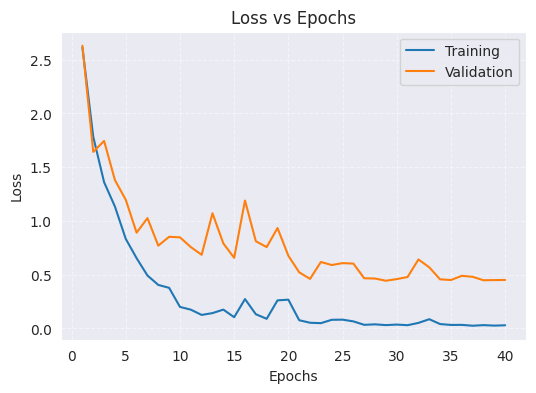

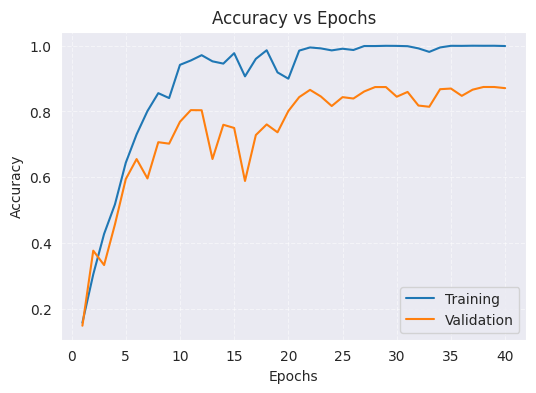

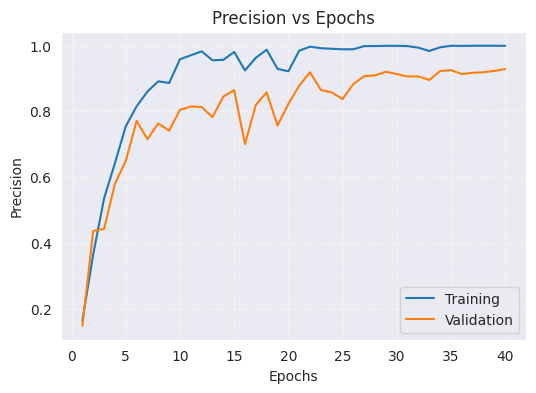

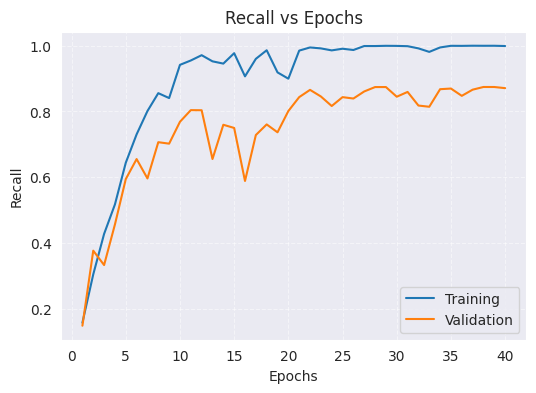

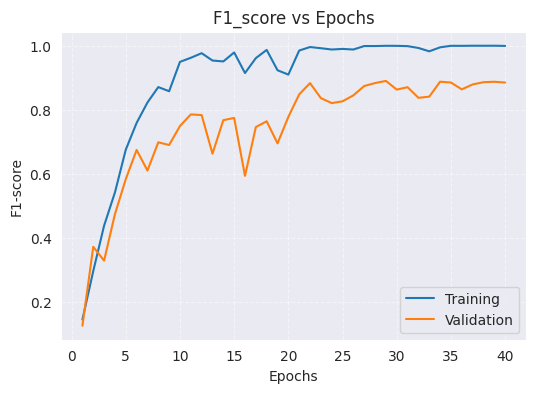

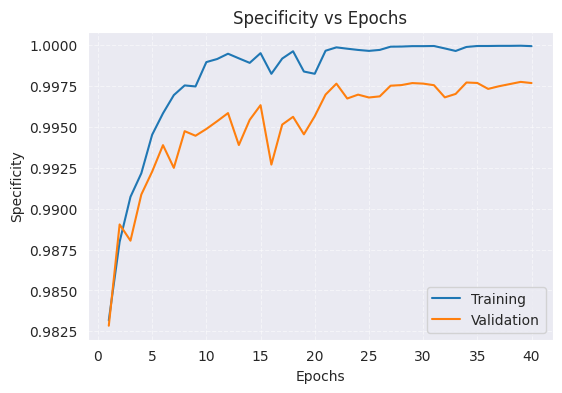

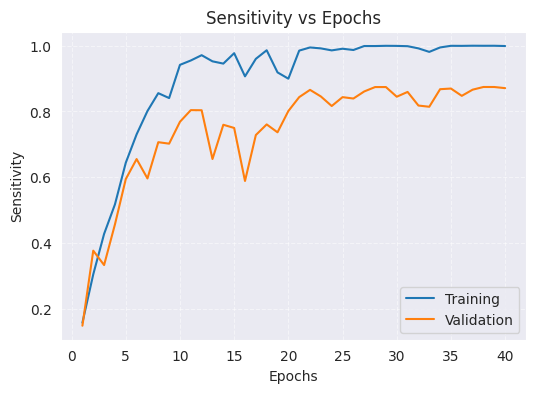

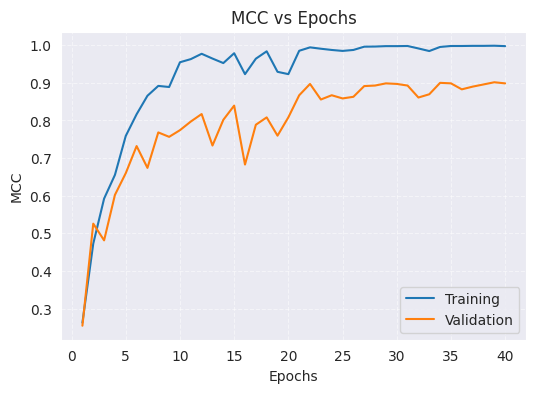

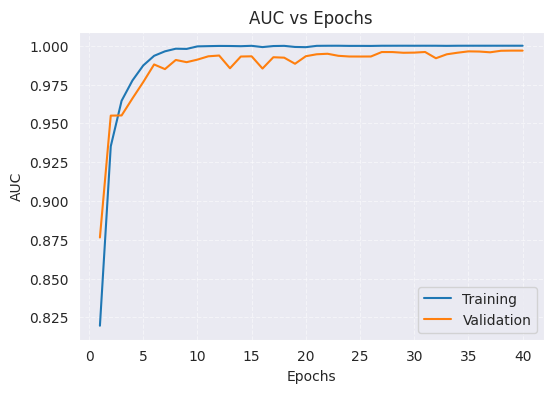

In [ ]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1_score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [ ]:
model.eval()
test_metrics = {k: v.clone().to(device) for k, v in train_metrics.items()}
test_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Testing Model")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

test_spec, test_sens = multiclass_specificity_sensitivity(
    all_targets, all_preds, num_classes
)

print(
    f"Metrics - loss: {test_loss/len(test_loader):.4f}, "
    f"accuracy: {test_metrics['acc'].compute().item():.4f}, "
    f"precision: {test_metrics['precision'].compute().item():.4f}, "
    f"recall: {test_metrics['recall'].compute().item():.4f}, "
    f"f1_score: {test_metrics['f1'].compute().item():.4f}, "
    f"specificity: {test_spec:.4f}, "
    f"sensitivity: {test_sens:.4f}, "
    f"mcc: {test_metrics['mcc'].compute().item():.4f}, "
    f"auc: {test_metrics['auc'].compute().item():.4f}"
)


Testing Model: 100%|██████████| 56/56 [00:12<00:00,  4.33it/s]

Metrics - loss: 0.3611, accuracy: 0.8534, precision: 0.8846, recall: 0.8534, f1_score: 0.8603, specificity: 0.9975, sensitivity: 0.8534, mcc: 0.8921, auc: 0.9977


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = [idx_to_class[i] for i in range(num_classes)]



# -------- CLASSIFICATION REPORT --------
print("\nClassification Report (Test Set):\n")

report = classification_report(
    all_targets,
    all_preds,
    target_names=class_names,
    digits=4,
    zero_division=0
)
print(report)



Classification Report (Test Set):

                        precision    recall  f1-score   support

        Astrocitoma T1     0.9167    0.9429    0.9296        35
      Astrocitoma T1C+     0.9556    0.9348    0.9451        46
        Astrocitoma T2     0.8438    0.7941    0.8182        34
          Carcinoma T1     0.9286    1.0000    0.9630        13
        Carcinoma T1C+     1.0000    1.0000    1.0000        22
          Carcinoma T2     1.0000    0.9333    0.9655        15
         Ependimoma T1     1.0000    1.0000    1.0000         9
       Ependimoma T1C+     1.0000    0.8000    0.8889        10
         Ependimoma T2     0.8889    0.7273    0.8000        11
      Ganglioglioma T1     1.0000    1.0000    1.0000         4
    Ganglioglioma T1C+     0.7500    1.0000    0.8571         3
      Ganglioglioma T2     1.0000    0.6000    0.7500         5
          Germinoma T1     1.0000    0.4000    0.5714         5
        Germinoma T1C+     0.8000    1.0000    0.8889         8
   

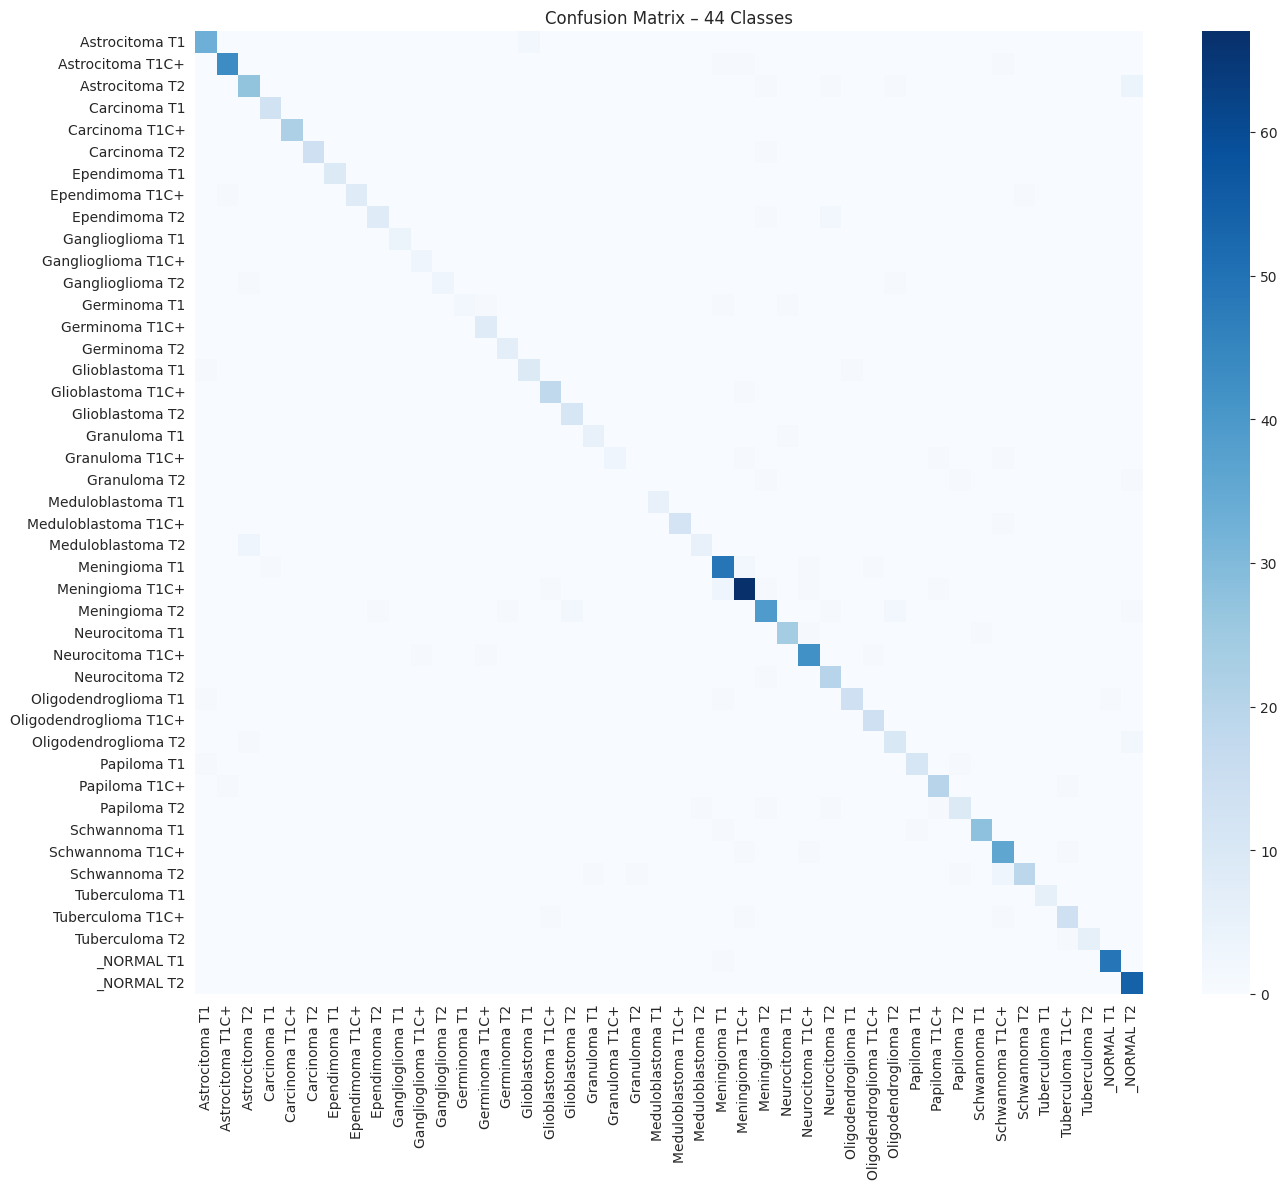

In [ ]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Confusion Matrix – 44 Classes")
plt.tight_layout()
plt.show()
